In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from tensorflow import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

## Fashion MMIST dataset

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
X_train_full.shape

(60000, 28, 28)

In [4]:
X_train_full.dtype

dtype('uint8')

In [5]:
# For faster training, let's use a subset 10,000
X_train, y_train = X_train_full[:10000] / 255.0, y_train_full[:10000]

## Building a NN model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

def create_model(): 
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(300, activation='relu'),
        Dense(100, activation='relu'),
        Dense(10, activation='softmax'),
    ])
    return model

In [7]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


## Helper functions for plotting

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_lr(history):
    learning_rate = history.history['lr']
    epochs = range(1, len(learning_rate) + 1)
    plt.plot(epochs, learning_rate)
    plt.title('Learning rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning rate')
    plt.show()

In [9]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

## 1. Constant Learning Rate

The constant learning rate is the default schedule in all Keras Optimizers. For example, in the SGD optimizer, the learning rate defaults to 0.01. To use a custom learning rate, simply instantiate an SGD optimizer and pass the argument learning_rate=0.01

In [10]:
# Create a new model
model = create_model()

In [11]:
# Learning rate defaults to 0.01 according to https://keras.io/api/optimizers/sgd/
# To use a custom Learning Rate
sgd = tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(
    optimizer=sgd, 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

history_constant = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_split=0.2,
    batch_size=64
)

Epoch 1/100
125/125 [==============================] - 1s 4ms/step - loss: 1.7004 - accuracy: 0.5106 - val_loss: 1.2321 - val_accuracy: 0.6475
Epoch 2/100
125/125 [==============================] - 0s 3ms/step - loss: 1.0118 - accuracy: 0.7003 - val_loss: 0.8965 - val_accuracy: 0.7180
Epoch 3/100
125/125 [==============================] - 0s 3ms/step - loss: 0.8054 - accuracy: 0.7416 - val_loss: 0.7813 - val_accuracy: 0.7330
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 0.7119 - accuracy: 0.7701 - val_loss: 0.7119 - val_accuracy: 0.7460
Epoch 5/100
125/125 [==============================] - 0s 3ms/step - loss: 0.6585 - accuracy: 0.7781 - val_loss: 0.6670 - val_accuracy: 0.7730
Epoch 6/100
125/125 [==============================] - 0s 3ms/step - loss: 0.6171 - accuracy: 0.7945 - val_loss: 0.6297 - val_accuracy: 0.7795
Epoch 7/100
125/125 [==============================] - 0s 3ms/step - loss: 0.5862 - accuracy: 0.8041 - val_loss: 0.6071 - val_accuracy: 0.7840

Epoch 58/100
125/125 [==============================] - 0s 3ms/step - loss: 0.3089 - accuracy: 0.8954 - val_loss: 0.4254 - val_accuracy: 0.8545
Epoch 59/100
125/125 [==============================] - 0s 3ms/step - loss: 0.3086 - accuracy: 0.8939 - val_loss: 0.4569 - val_accuracy: 0.8415
Epoch 60/100
125/125 [==============================] - 0s 3ms/step - loss: 0.3074 - accuracy: 0.8949 - val_loss: 0.4203 - val_accuracy: 0.8545
Epoch 61/100
125/125 [==============================] - 0s 3ms/step - loss: 0.3053 - accuracy: 0.8940 - val_loss: 0.4470 - val_accuracy: 0.8495
Epoch 62/100
125/125 [==============================] - 0s 3ms/step - loss: 0.3018 - accuracy: 0.8955 - val_loss: 0.4266 - val_accuracy: 0.8510
Epoch 63/100
125/125 [==============================] - 0s 3ms/step - loss: 0.2986 - accuracy: 0.8982 - val_loss: 0.4248 - val_accuracy: 0.8585
Epoch 64/100
125/125 [==============================] - 0s 3ms/step - loss: 0.2971 - accuracy: 0.8961 - val_loss: 0.4289 - val_accuracy:

In [12]:
plot_metric(history_constant, 'accuracy')

## 2. Time-Based Decay

Time-based decay is one of the most popular learning rate schedules. Formally, the time-based decay is defined as:

**learning_rate = lr * 1 / (1 + decay * epoch)**

where lr is the previous learning rate, decay is a hyperparameter and epoch is the iteration number. When the decay is zero, this has no effect on changing the learning rate. When the decay is specified, it will decrease the learning rate from the previous epoch by the given fixed amount. The value of decay is normally implemented as

In [13]:
# Create a new model
model = create_model()

model.compile(
    optimizer='sgd', # Learning rate defaults to 0.01
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the learning rate schedule function
initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate / epochs

def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

history_time_based_decay = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_split=0.2,
    batch_size=64,
    callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)],
)

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
125/125 [==============================] - 1s 4ms/step - loss: 1.5507 - accuracy: 0.5650 - val_loss: 1.1436 - val_accuracy: 0.6615
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009998999876494932.
125/125 [==============================] - 0s 3ms/step - loss: 0.9663 - accuracy: 0.6949 - val_loss: 0.8811 - val_accuracy: 0.7135
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009997000136010244.
125/125 [==============================] - 0s 3ms/step - loss: 0.7951 - accuracy: 0.7374 - val_loss: 0.7815 - val_accuracy: 0.7295
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009994001785933966.
125/125 [==============================] - 0s 3ms/step - loss: 0.7127 - accuracy: 0.7607 - val_loss: 0.7240 - val_accuracy: 0.7530
Epoch 5/100

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0099900060566793

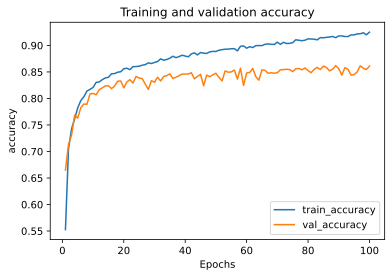

In [15]:
plot_metric(history_time_based_decay, 'accuracy')

In [16]:
plot_lr(history_time_based_decay)

## 3. Step decay

Another popular learning rate schedule is to systematically drop the learning rate at specific times during training. Formally, it is defined as:

**learning_rate = initial_lr * drop_rate^floor(epoch / epochs_drop)**

Where initial_lr is the initial learning rate such as 0.01, the drop_rate is the amount that the learning rate is modified each time if it is changed, epoch is the current epoch number, and epochs_drop is how often to change the learning rate such as 10 epochs. Similarly, we can implement this by defining a step decay function lr_step_decay() and pass it to LearningRateScheduler callback.

In [17]:
# Create a new model
model = create_model()

model.compile(
    optimizer='sgd', # Learning rate defaults to 0.01
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [18]:
# Define the learning rate schedule function
initial_learning_rate = 0.01

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

# Fit the model to the training data
history_step_decay = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_split=0.2,
    batch_size=64,
    callbacks=[LearningRateScheduler(lr_step_decay, verbose=1)],
)

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
125/125 [==============================] - 1s 3ms/step - loss: 1.5690 - accuracy: 0.5546 - val_loss: 1.1507 - val_accuracy: 0.6465
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
125/125 [==============================] - 0s 3ms/step - loss: 0.9802 - accuracy: 0.6862 - val_loss: 0.8965 - val_accuracy: 0.6920
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
125/125 [==============================] - 0s 3ms/step - loss: 0.8157 - accuracy: 0.7272 - val_loss: 0.7854 - val_accuracy: 0.7310
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
125/125 [==============================] - 0s 3ms/step - loss: 0.7314 - accuracy: 0.7563 - val_loss: 0.7233 - val_accuracy: 0.7575
Epoch 5/100

Epoch 00005: LearningRateScheduler reducing learning rate to 0.01.
125/125 [==============================] - 0s 3ms/step - loss: 0.6763 - accu

125/125 [==============================] - 0s 3ms/step - loss: 0.4258 - accuracy: 0.8577 - val_loss: 0.4853 - val_accuracy: 0.8360
Epoch 78/100

Epoch 00078: LearningRateScheduler reducing learning rate to 7.8125e-05.
125/125 [==============================] - 0s 3ms/step - loss: 0.4258 - accuracy: 0.8585 - val_loss: 0.4853 - val_accuracy: 0.8355
Epoch 79/100

Epoch 00079: LearningRateScheduler reducing learning rate to 7.8125e-05.
125/125 [==============================] - 0s 3ms/step - loss: 0.4257 - accuracy: 0.8579 - val_loss: 0.4853 - val_accuracy: 0.8365
Epoch 80/100

Epoch 00080: LearningRateScheduler reducing learning rate to 7.8125e-05.
125/125 [==============================] - 0s 3ms/step - loss: 0.4257 - accuracy: 0.8584 - val_loss: 0.4852 - val_accuracy: 0.8360
Epoch 81/100

Epoch 00081: LearningRateScheduler reducing learning rate to 3.90625e-05.
125/125 [==============================] - 0s 2ms/step - loss: 0.4256 - accuracy: 0.8577 - val_loss: 0.4852 - val_accuracy: 0.8

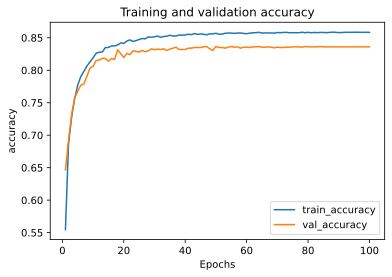

In [19]:
plot_metric(history_step_decay, 'accuracy')

In [20]:
plot_lr(history_step_decay)

## 4. Exponential Decay

Formally, it is defined as:

**learning_rate = initial_lr * e^(âˆ’k * epoch)**

Where initial_lr is the initial learning rate such as 0.01, k is a hyperparameter, and epoch is the current epoch number. Similarly, we can implement this by defining an exponential decay function lr_exp_decay() and pass it to LearningRateScheduler callback.

In [21]:
# Create a new model
model = create_model()

model.compile(
    optimizer='sgd', # Learning rate defaults to 0.01
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [22]:
initial_learning_rate = 0.01

def lr_exp_decay(epoch, lr):
    k = 0.1
    return initial_learning_rate * math.exp(-k*epoch)

# Fit the model to the training data
history_exp_decay = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    validation_split=0.2,
    batch_size=64,
    callbacks=[LearningRateScheduler(lr_exp_decay, verbose=1)],
)

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
125/125 [==============================] - 1s 3ms/step - loss: 1.6550 - accuracy: 0.5334 - val_loss: 1.1998 - val_accuracy: 0.6380
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009048374180359595.
125/125 [==============================] - 0s 3ms/step - loss: 1.0084 - accuracy: 0.6834 - val_loss: 0.9168 - val_accuracy: 0.6745
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.008187307530779819.
125/125 [==============================] - 0s 3ms/step - loss: 0.8345 - accuracy: 0.7221 - val_loss: 0.8159 - val_accuracy: 0.7000
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 0.007408182206817179.
125/125 [==============================] - 0s 3ms/step - loss: 0.7537 - accuracy: 0.7515 - val_loss: 0.7586 - val_accuracy: 0.7310
Epoch 5/100

Epoch 00005: LearningRateScheduler reducing learning rate to 0.006703200460356393.
125/125 [===

Epoch 37/100

Epoch 00037: LearningRateScheduler reducing learning rate to 0.0002732372244729256.
125/125 [==============================] - 0s 3ms/step - loss: 0.5100 - accuracy: 0.8310 - val_loss: 0.5539 - val_accuracy: 0.8135
Epoch 38/100

Epoch 00038: LearningRateScheduler reducing learning rate to 0.00024723526470339386.
125/125 [==============================] - 0s 3ms/step - loss: 0.5095 - accuracy: 0.8305 - val_loss: 0.5535 - val_accuracy: 0.8165
Epoch 39/100

Epoch 00039: LearningRateScheduler reducing learning rate to 0.00022370771856165591.
125/125 [==============================] - 0s 3ms/step - loss: 0.5093 - accuracy: 0.8305 - val_loss: 0.5533 - val_accuracy: 0.8140
Epoch 40/100

Epoch 00040: LearningRateScheduler reducing learning rate to 0.0002024191144580438.
125/125 [==============================] - 0s 3ms/step - loss: 0.5088 - accuracy: 0.8311 - val_loss: 0.5534 - val_accuracy: 0.8130
Epoch 41/100

Epoch 00041: LearningRateScheduler reducing learning rate to 0.00018

In [23]:
plot_metric(history_exp_decay, 'accuracy')

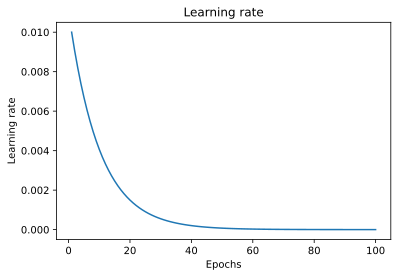

In [24]:
plot_lr(history_exp_decay)

## Compare model accuracy

In [25]:
epochs = range(1, 101)
plt.plot(epochs,history_constant.history['val_accuracy'],label='Constant')
plt.plot(epochs,history_time_based_decay.history['val_accuracy'],label='Time-based')
plt.plot(epochs,history_step_decay.history['val_accuracy'],label='Step decay')
plt.plot(epochs,history_exp_decay.history['val_accuracy'],label='Exponential decay')
plt.legend(loc=0)
plt.xlabel('epochs')
plt.show()

Looks like Constant and Time-based learning rates have better performance than Step decay and Exponential decay for this dataset and architecture.